In [1]:
"""
activations during training and gradients during backprop
will help us understand the history of the later models -> RNNs, GRUs, Transformers, etc
while RNNs are universal approimators, not easily optimizable with first order gradient techniques that we use
why are they not optimazable? key is to understand gradients and activations and how they behave during trainnig
GRUs and Transformers have tried to improve that situation 
"""

'\nactivations during training and gradients during backprop\nwill help us understand the history of the later models -> RNNs, GRUs, Transformers, etc\nwhile RNNs are universal approimators, not easily optimizable with first order gradient techniques that we use\nwhy are they not optimazable? key is to understand gradients and activations and how they behave during trainnig\nGRUs and Transformers have tried to improve that situation \n'

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline


In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)


32033

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [75]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# we want to set std dev to be gain / sqrt(fan in), we do this mult below by gain / sqrt(fan in)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / (n_embd * block_size)**0.5 #0.2
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # make logits initally be close to 0
b2 = torch.randn(vocab_size,                      generator=g) * 0 # make logits at init be close to 0

bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)
bnmean_running = torch.zeros(1, n_hidden)
bnstd_running = torch.ones(1, n_hidden)

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


12297


In [ ]:
# how to keep pre-activations from expanding
# https://arxiv.org/pdf/1502.01852

# also studies backpop, gradients need to be well behaved
# turns out if you keep activations in check, gradients are okay too

# how to init weights in pytorch?
# torch.nn.init.kaiming_normal_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu', generator=None)
# mode - normalize activations or gradients? paper says doesnt matter, keep it as default - 'fan-in'
# nonlinearity type - gain will be different
# why do we need gain? tanh is squashing function. to fight squeezing in, we need to boost them to normalize it
# a couple years ago, init of weights mattered to keep distribution of activations and gradients in check 
# now there modern innovations that keep everything more well behaved and stable:
# -> residual connections
# -> normalization layers (batch normalization, layer normalization, group normalization)
# -> better optimizers (not just SGD, but also Adam, RMSProp) 

# in practice Karpathy divides layer element wise by sqrt of fan in
# if we want to be more precise, we want to set the standard deviation tp be = gain / sqrt fan in


In [58]:
# when you mutlipely by 0.2, scales std to be 0.2
(torch.randn(10000) * 0.2).std()

tensor(0.2011)

tensor(-0.0142) tensor(0.9928)
tensor(0.0041) tensor(0.9856)


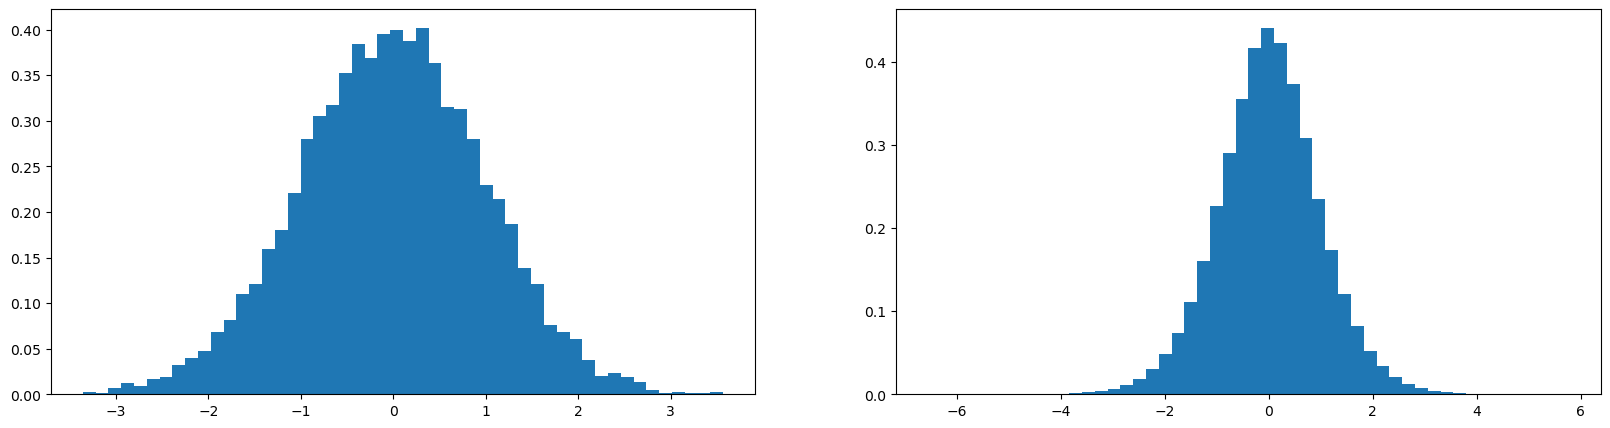

In [4]:


x = torch.randn(1000, 10)
w = torch.randn(10, 200)  / 10**0.5 # divide by sqrt of fanin (number of inputs)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);


In [61]:
hpreact.shape

torch.Size([32, 200])

In [64]:
hpreact.mean(0, keepdims=True).shape

torch.Size([1, 200])

In [66]:
hpreact.std(0, keepdims=True).shape

torch.Size([1, 200])

In [76]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer

  # insight in batch normalization paper, just normalize them!
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation

  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
    
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
    
  


      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In [46]:
h.shape

torch.Size([32, 200])

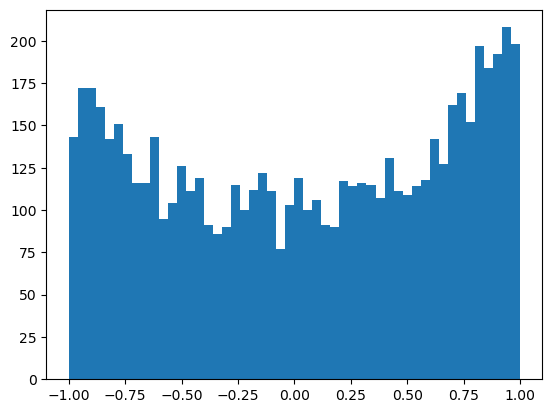

In [47]:
plt.hist(h.view(-1).tolist(), 50);

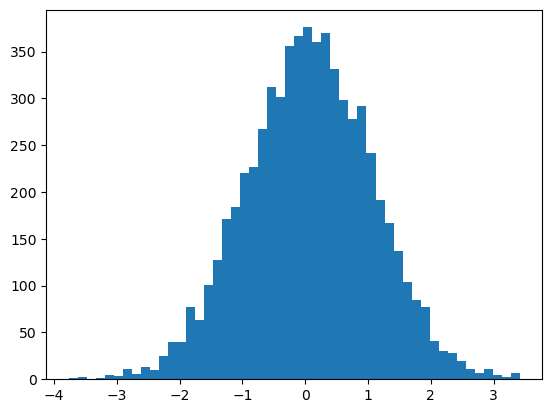

In [48]:
plt.hist(hpreact.view(-1).tolist(), 50);

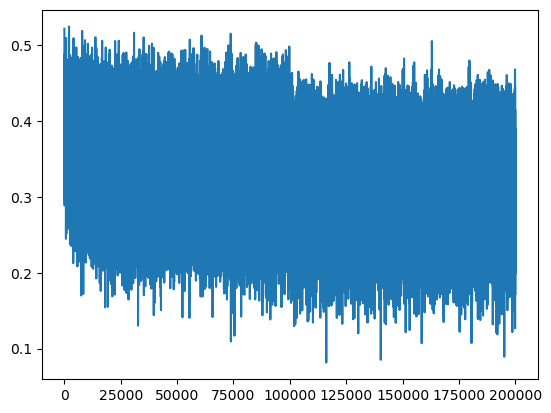

In [15]:
plt.plot(lossi)


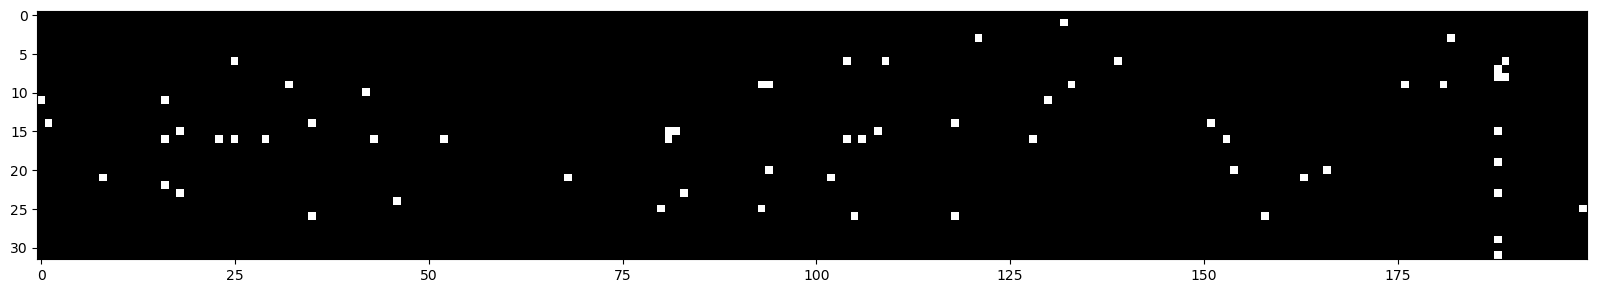

In [49]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')


In [72]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)


In [77]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdims=True)) / hpreact.std(0, keepdims=True) + bnbias
  # hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

"""
before lessening b2 and W2, losses were: 
train 2.1282482147216797
val 2.1710422039031982

after decreasing b2 and W2, losses are:
train 2.069589138031006
val 2.1310746669769287

after fixing tanh saturation:
train 2.0355966091156006
val 2.1026785373687744

after kaiming init for W1, we get roughly similar losses:
train 2.0376641750335693
val 2.106989622116089

# batch normalization: not huge improvement, but this batch normalization is indispensable when training larger nns
train 2.0668270587921143
val 2.104844808578491

# running estimate of bnmean and bnstd without second stage calculation:
train 2.06659197807312
val 2.1050572395324707
[pretty similar, didnt need a second stage for estimation!]

"""


train 2.06659197807312
val 2.1050572395324707


'\nbefore lessening b2 and W2, losses were: \ntrain 2.1282482147216797\nval 2.1710422039031982\n\nafter decreasing b2 and W2, losses are:\ntrain 2.069589138031006\nval 2.1310746669769287\n\nafter fixing tanh saturation:\ntrain 2.0355966091156006\nval 2.1026785373687744\n\nafter kaiming init for W1, we get roughly similar losses:\ntrain 2.0376641750335693\nval 2.106989622116089\n\n# batch normalization: not huge improvement, but this batch normalization is indispensable when training larger nns\ntrain 2.0668270587921143\nval 2.104844808578491\n\n'

In [17]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word


carman.
amille.
khyrmyn.
reet.
khalayane.
mahnen.
deliah.
jareei.
nellara.
chaiivon.
legen.
ham.
jorn.
quintin.
lilea.
jadiquinterri.
jarysia.
kael.
dustine.
deciia.


Improvements to this neural net
Initialization of NN is off - the init loss is too high
prob for any character at init is 1/27 -> loss should be ~tensor(3.2958)
-> we want logits to be roughly 0, or roughly equal
-> b2 to be init to 0 and W2 to be close to 0

the logits are okay, but there is a deeper problem with the activations of the hidden layer

h.shape:

torch.Size([32, 200])

plt.hist(h.view(-1).tolist(), 50);


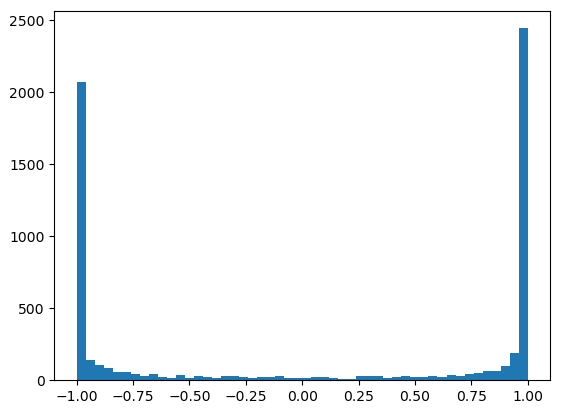

most values are -1 and 1, tanh is very active

why is this? because the preactivation distribution is very broad:

plt.hist(hpreact.view(-1).tolist(), 50);

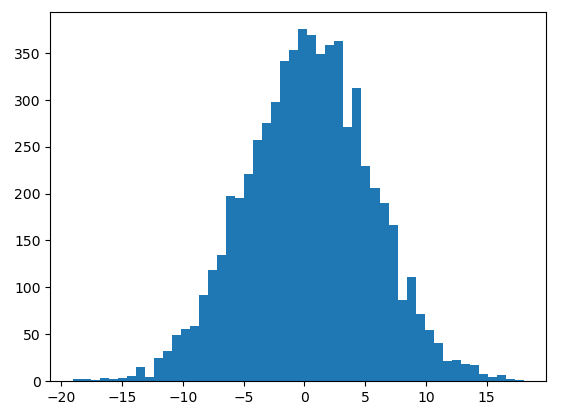

Why is this a problem? Lets look at the micrograd code we had written:

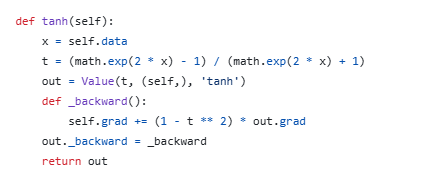

When the outputs of the preactivation are 1 or -1, then we set self.grad = (1 - t*2) * out.grad, whatever out.grad was, we are killing the backprop because our t value is 1 or -1
-> when tanh is 0, tanh unit is inactive and gradient passes through, the closer you are to 1 or -1, the more the grad is squashed
-> if all of these outputs of h (after the tanh) are 1 or -1, the gradients that are flowing through tanh are stopped

lets see the health of the h layer (after tanh)

plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

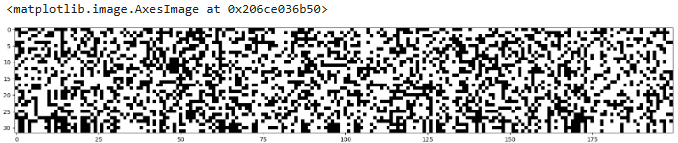

32 * 200 shape ^
a lot is white, tanh neurons are very active, all are in the flat tail, back gradient will be destroyed
if entire column is white -> dead neuron -> no single example activates it in the non flat region, and it will never learn
no dead neurons here, but we lets fix this
not just true for tanh, sigmoid has an issue (it is also squashing), also ReLU (before 0 it squashes), 
when can these issues happen? at init of the weights and biases, but also if learning rate is too high, the gradient knocks neuron out of the data manifold, and the neuron remains dead forever. "brain damage" in the mind of a neural network
-> leaky ReLU does suffer as much, ELU might suffer

-> on our case there are too many extreme values in h, but it is not optimal, lets fix this
-> hpreact is too extreme, too far off from 0, make it closer to 0
-> set b1 to 0, or something close to 0, squash W1

change: 
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden,                        generator=g) * 0.01

hpreact distribution is better:
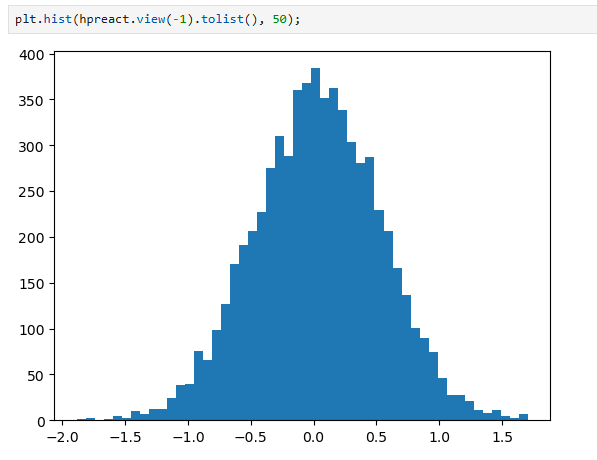

h distribution is also better:
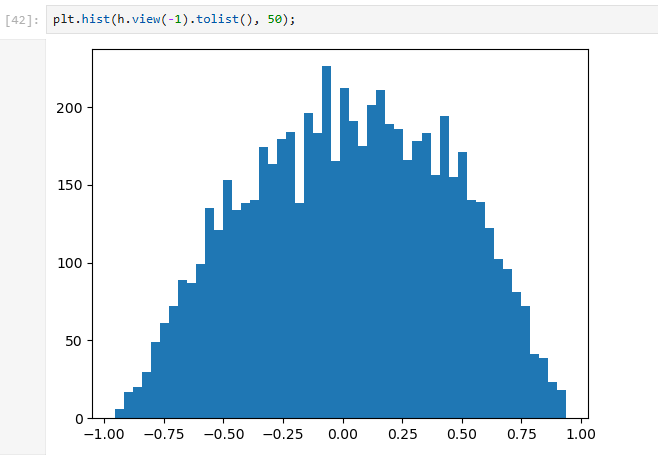

no white anymore!
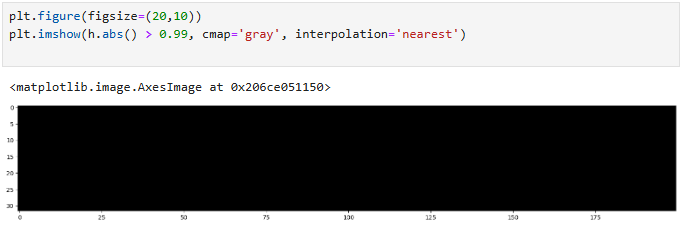


maybe add some white neurons...

W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01

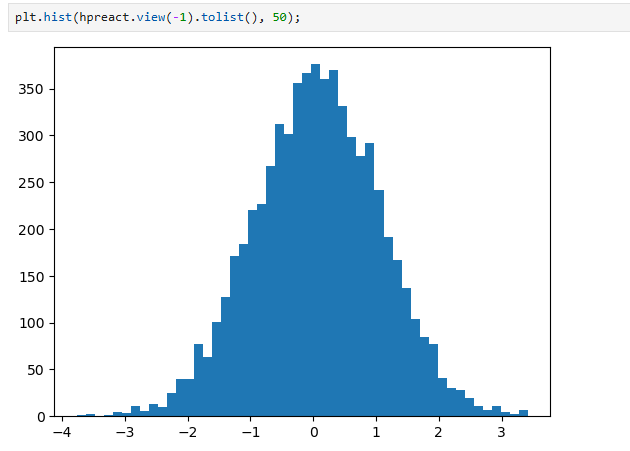

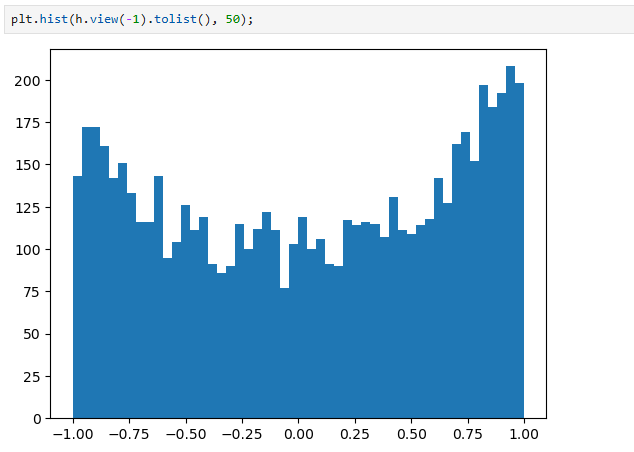

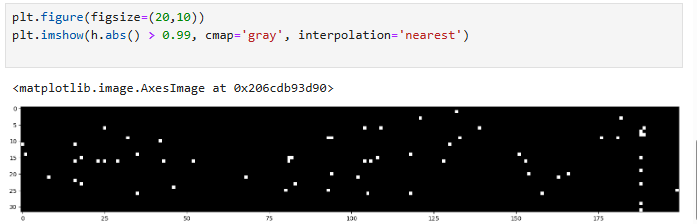

how do you come up with magic numbers like 0.2?

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # make logits initally be close to 0
b2 = torch.randn(vocab_size,                      generator=g) * 0 # make logits at init be close to 0




In [36]:
# what init loss should be around...
-torch.tensor(1/27.0).log()

tensor(3.2958)

TLDR:
- we are using batch normalization to control the statistics of the activations in the neural net
- common to sprinkle these layers with mutlipliations, like after linear layer or conv layer
- two parameters in batch normalization internally - gain and bias, which are trained
- also has two buffers, the running mean and running std dev and not trained using backprop, trained with janky update of running calculation (0.999 * old + 0.001 * new)
- what is the layer doing?:
- - calculating mean and std of preactivation of examples in batch
  - centering the batch to be unit gaussian initially.
  - then its ofsetting and scaling the distribution with the learned bias and gain of that batch norm layer
  - on top of that, keeping track of mean and std of inputs, so that for single example inference we dont have to recalculate all of the mean and std all the time


So why does init not matter as much anymore?

one of the reasons: Batch Normalization: Accelerating Deep Network Training b
y
Reducing Internal Covariate Shift
https://arxiv.org/pdf/1502.031

made it possible to reliably train deep neural networks reliably

we have hidden states hpreact
-> we dont want to be too small, then tanh isnt doing anything
-> but we dont want to saturate tanh, otherwise neuron isnt learning
-> we want roughly gaussian 0 mean 1 std dev at least at init

insight from paper
-> take the hidden states, and make them roughly gaussian
-> normalizing perfectly differentiable

from the paper:
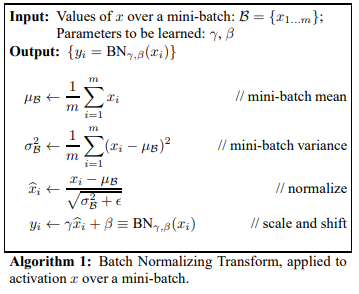

above:   hpreact = (hpreact - hpreact.mean(0, keepdims=True)) / hpreact.std(0, keepdims=True)
every single neuron will be unit gaussian on these 32 examples in the batch
normalizing these batches

we dont want to be gaussian at init, but want the neural net to move the preact around diffuse, sharp, more / less trigger happy

in addition to normalizing, lets introduce scale and shift
-> scale by gain, offset by bias

batch normalization will not do much in this case
-> but when we have a much deeper neural network, it will become much harder to tune the weight matrices to make sure preact are roughly gaussian
-> compared to that, it would become much easier to sprinkle these batch normalization layers throughout the neural network
-> in practice, when we have a linear layer (a @ b + c) or convulational layer, it is customary to append a batch normalization layer to control the scale of the activations at every point of the neural net, controls scale of the actiations, dont need precise mathematics for components in the neural net (e.g. the kaimin init we introduced for W1)
-> significantly stabilizes trainnig for deep nn

-> cost: we were batching for effiency reasons, but now with batch normalization, the logits are not just a function of that input, but is also a function of all of the other examples in the batch
-> you would think this would be undesirable, but in a strange way, helps neural net not overfit (it is like a regularizes the neural net)
-> this second order effect makes it even better -> even if we want to try to create better alternatives to batch normalization, we are incentivized not to becayse of the first order and second order benefits of batch normalization

-> no one likes that the examples are grouped togeher in forward pass and backward pass, it leads to strange side effects
-> how do we do inference for just one example? set batch norm mean and std dev.  (# calibrate the batch norm at the end of training
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

clamp values at inference time:
hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias

-> still, no once wants to estimate this bnmean and bnbias as a second step of neural network training
-> instead we can estimate this in a running manner!

  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------

two more notes:
1) 
 + epsilon: when we normalize the batch, we dont want to divide by 0
-> this will only happen when the stddev of our batch is exactly 0, which is not very likely, so we skip it here

2) 


  # insight in batch normalization paper, just normalize them!
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation

  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
    
we dont need b1 anymore, because when we add to hpreact we are subtracting it when we do - bnmeani, remove it)67

real life example:

# res net
bottleneck block
init - we init the layers
forward() - forawrd pass
bottleneck blocks are being stacked

forward():
conv - bias is False
batchnrom
relu

conv - bias is False
batchnrom
relu

conv - bias is False
batchnrom
relu

torch linear
https://docs.pytorch.org/docs/stable/generated/torch.nn.Linear.html

torch batcn norm:
https://docs.pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html

In [ ]:
# summary

In [128]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  # layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True


47024


In [129]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization


      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

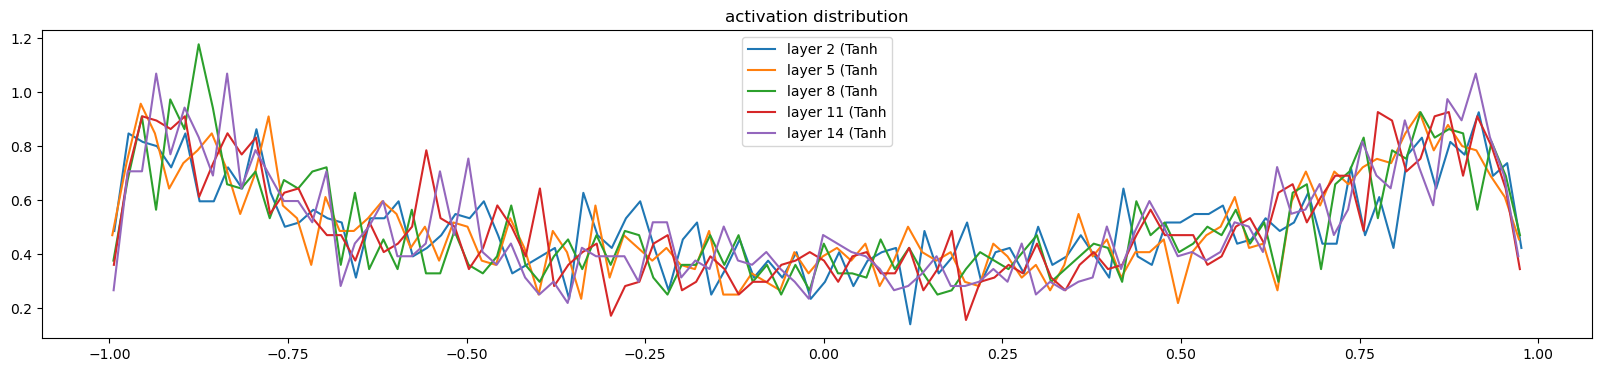

In [130]:
# visualize histograms, for tanh
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')


layer 2 (      Tanh): mean +0.000000, std 3.682950e-03
layer 5 (      Tanh): mean -0.000000, std 3.262606e-03
layer 8 (      Tanh): mean +0.000000, std 2.973727e-03
layer 11 (      Tanh): mean -0.000000, std 2.741108e-03
layer 14 (      Tanh): mean -0.000000, std 2.584293e-03


Text(0.5, 1.0, 'gradient distribution')

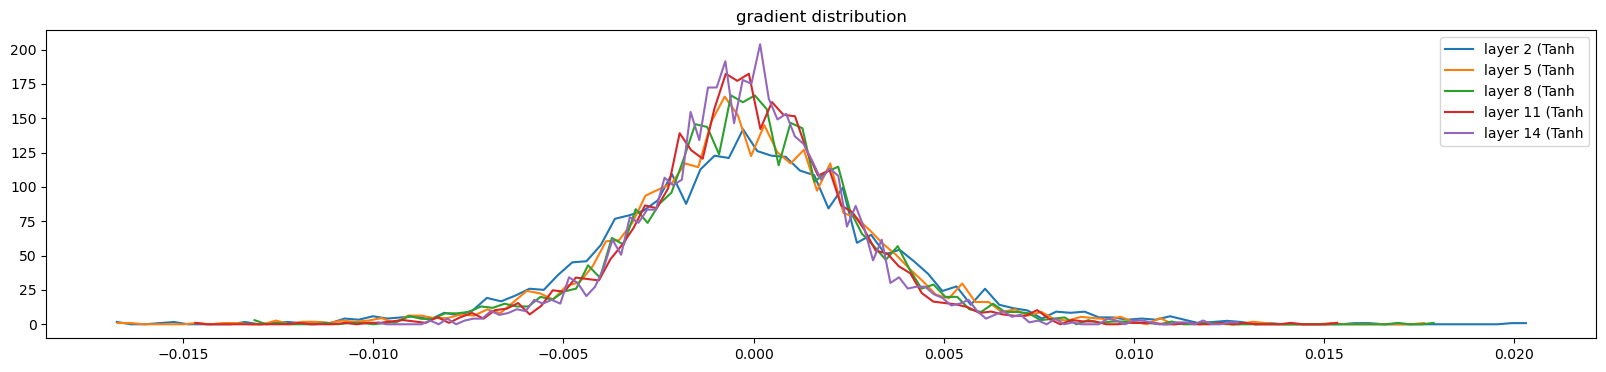

In [131]:
# visualize histograms, for tanh
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')


weight   (27, 10) | mean +0.000000 | std 1.019884e-02 | grad:data ratio 1.018845e-02
weight  (30, 100) | mean +0.000092 | std 8.238420e-03 | grad:data ratio 2.635836e-02
weight (100, 100) | mean +0.000031 | std 7.318103e-03 | grad:data ratio 4.377139e-02
weight (100, 100) | mean -0.000019 | std 6.662020e-03 | grad:data ratio 3.949893e-02
weight (100, 100) | mean -0.000019 | std 5.821511e-03 | grad:data ratio 3.468158e-02
weight (100, 100) | mean +0.000053 | std 5.445293e-03 | grad:data ratio 3.243365e-02
weight  (100, 27) | mean -0.000165 | std 1.046844e-02 | grad:data ratio 6.281260e-02


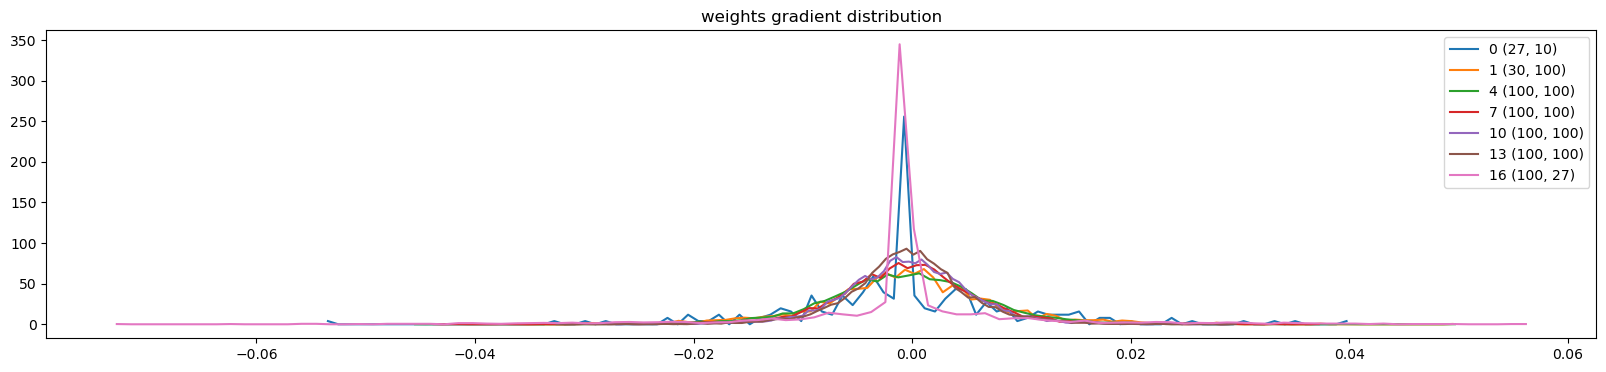

In [132]:
# parameter gradients
# problem: std of last layer weight gradient is 10 times larger than the other layers gradients
# -> we are training the last layer 10 times faster than the other layers
# visualize histograms

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');


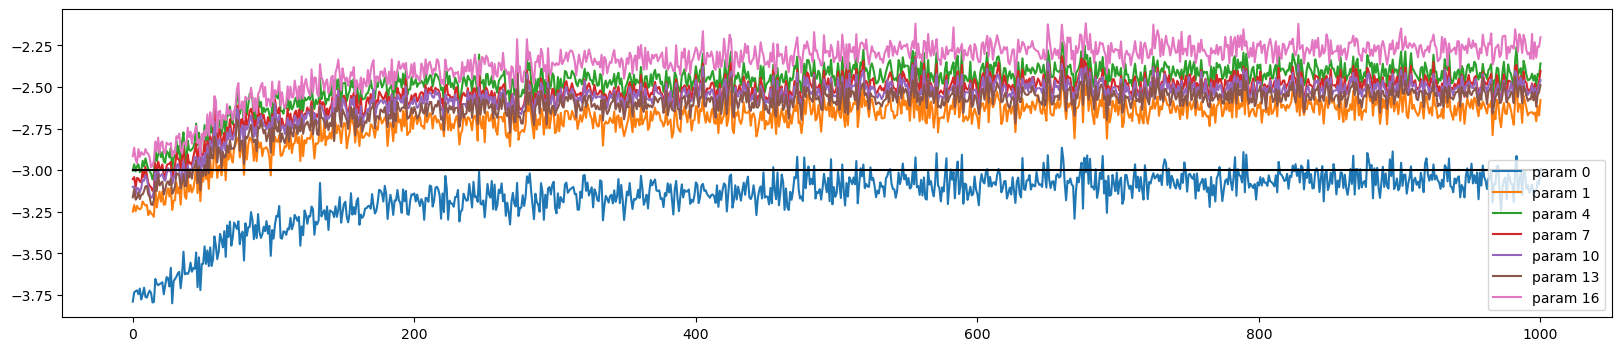

In [133]:
# update to data ratio, instead of grad to data ratio, for weights
# if the ratio is way under the 1e-3, we can tell learning rate is too low
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word


If we didnt have batch norm, we would need to set gain very very carefully:

if gain is 0.5:

with torch.no_grad():
  # last layer: make less confident
  # layers[-1].gamma *= 0.1
  layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 0.5


activations would be 
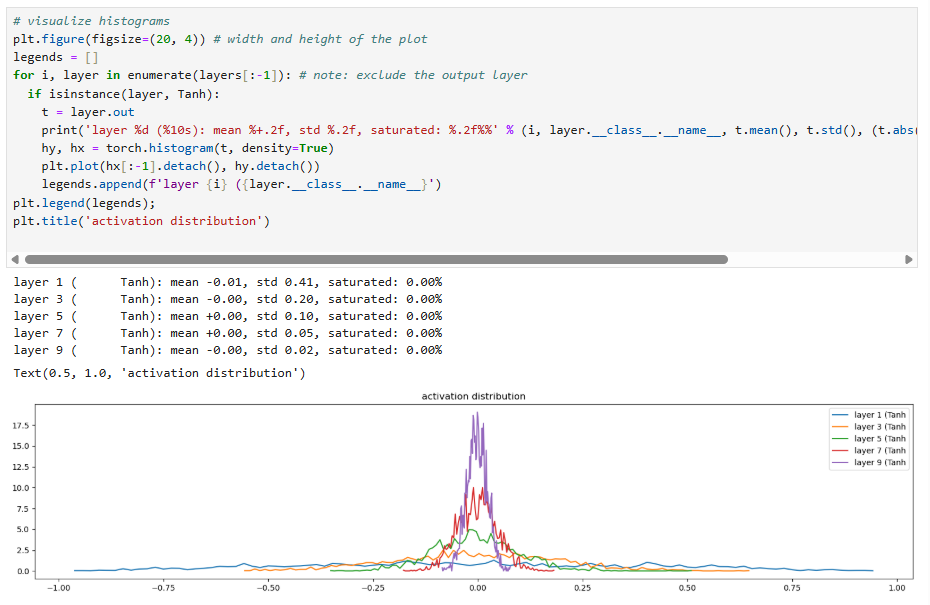

and gradients would be:
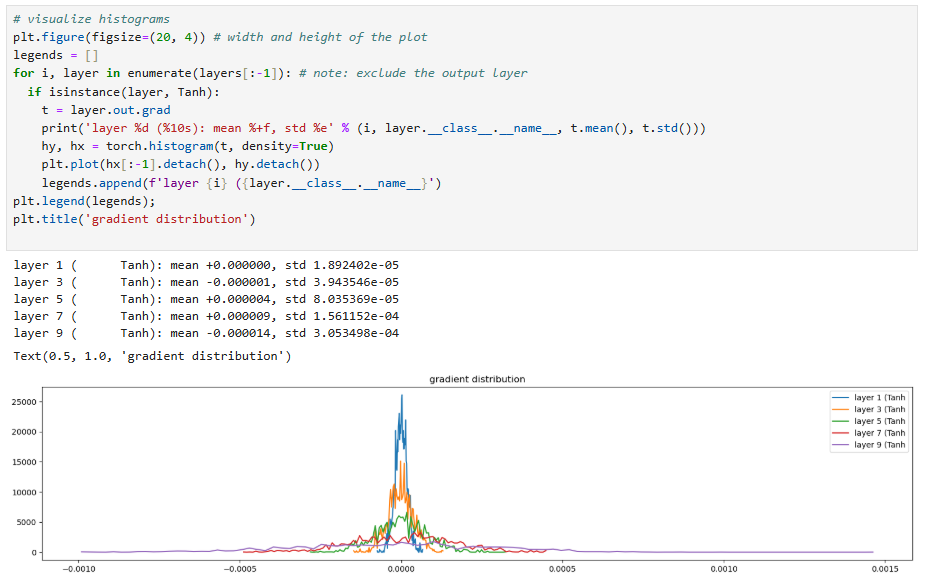

If gain is 3:

activations would be:

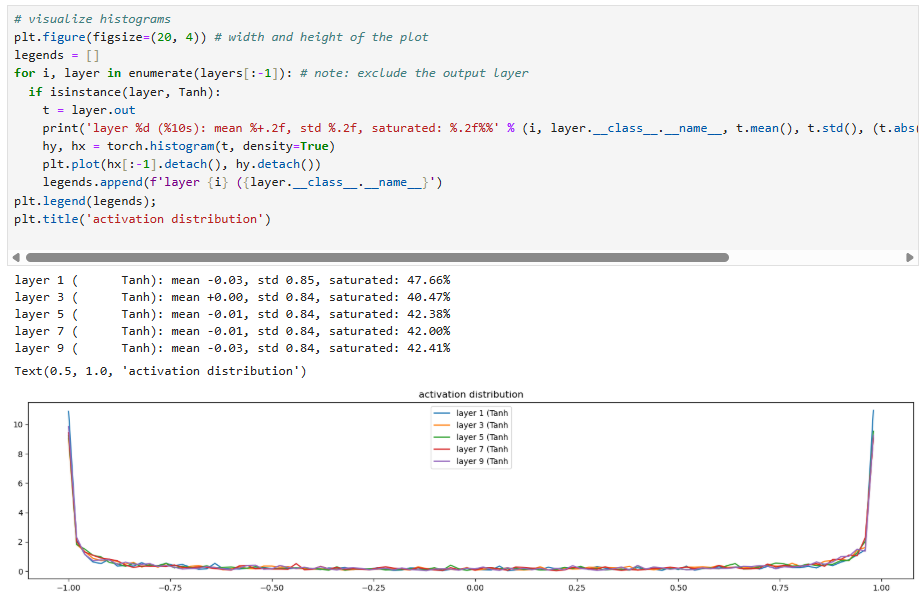

and gradients would be:

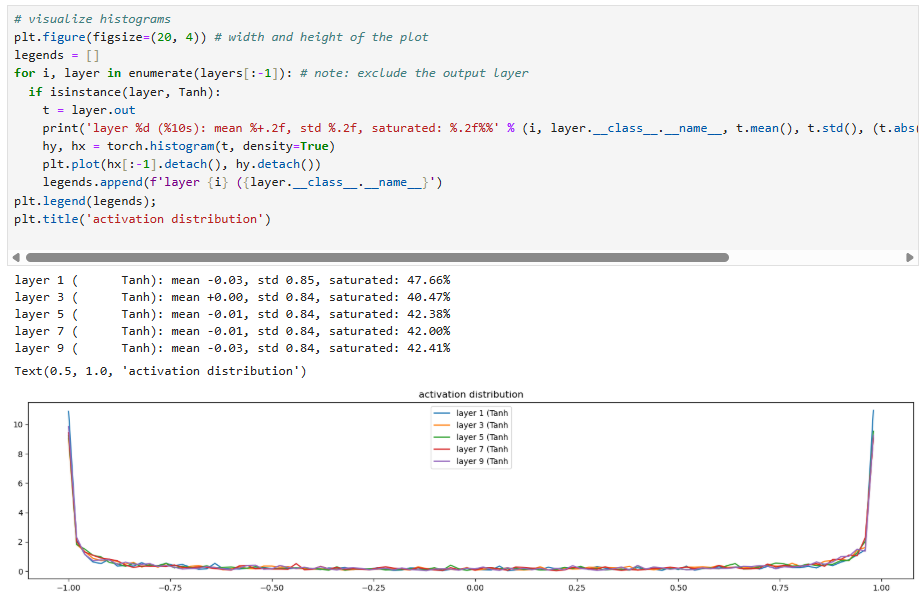

If we keep gain as 5/3, as we saw from pytorch reccomended gain for tanh:

activations are:
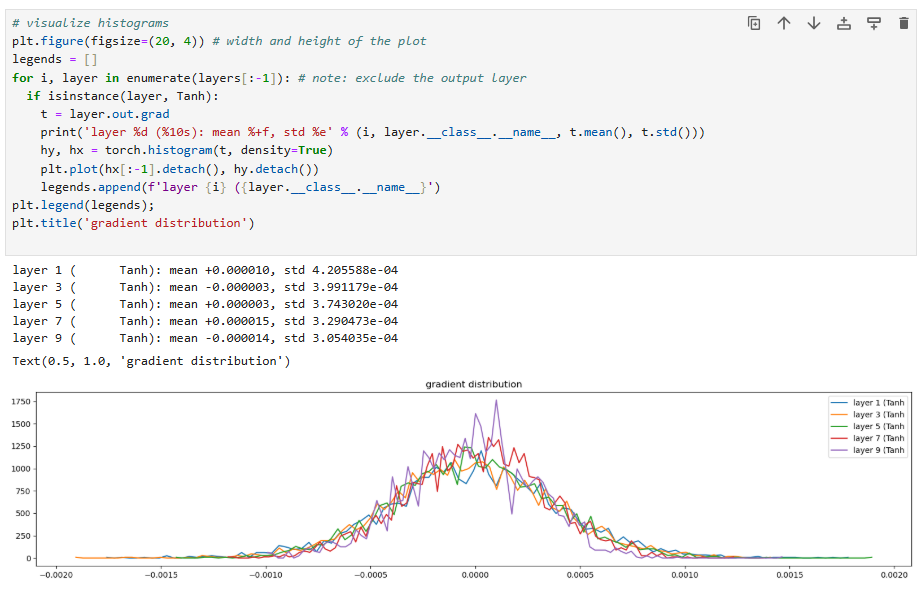

gradients are:

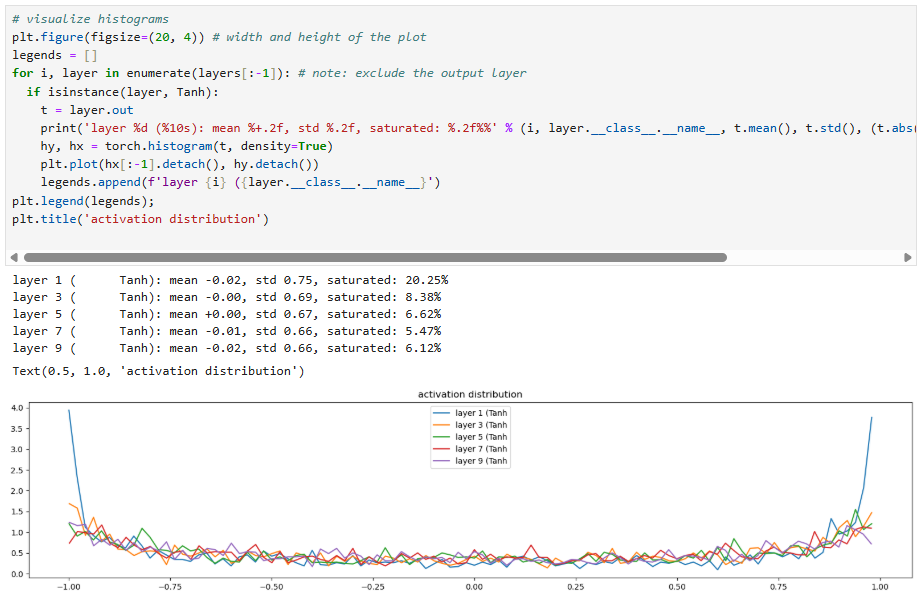

What do the activations and gradients look like when there is no tanh? Assume the gain is still 5/3

activations look like:
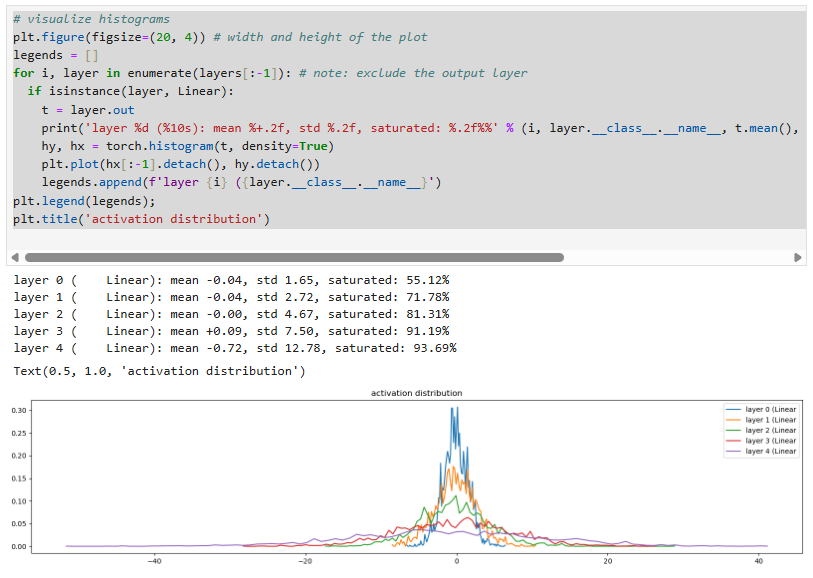
gradients look like:
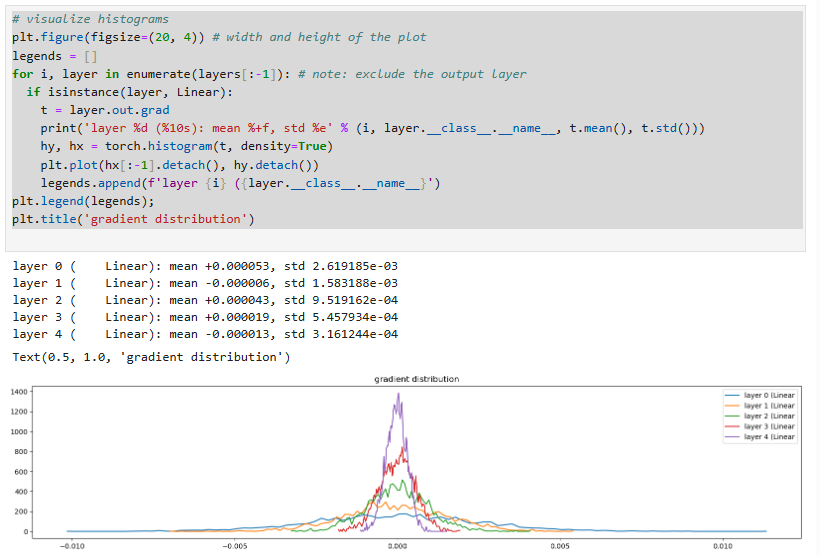

This is why, before batch norm, gain was very difficult to set.

The below two images occur after 1000 training cycles:

lets look at the grad:activation ratio for the weight matrices
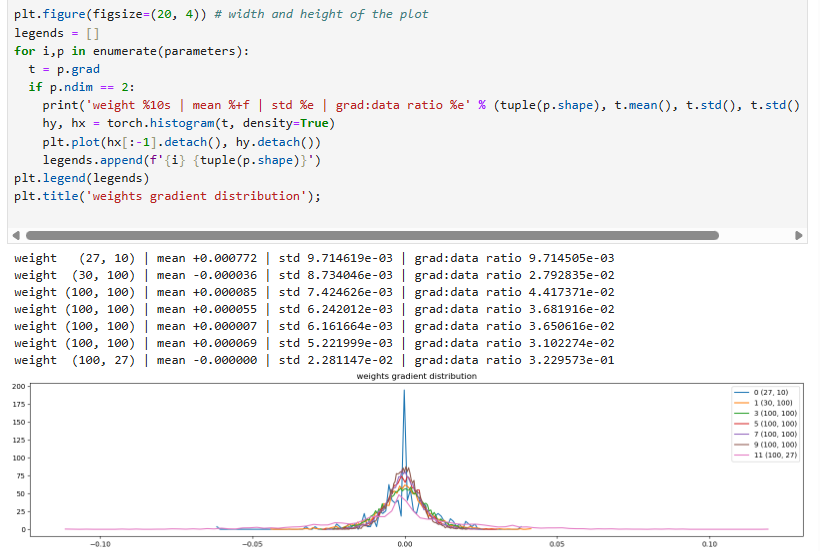

lets look at update (lr * grad) : activation ratio as we train the neural net:
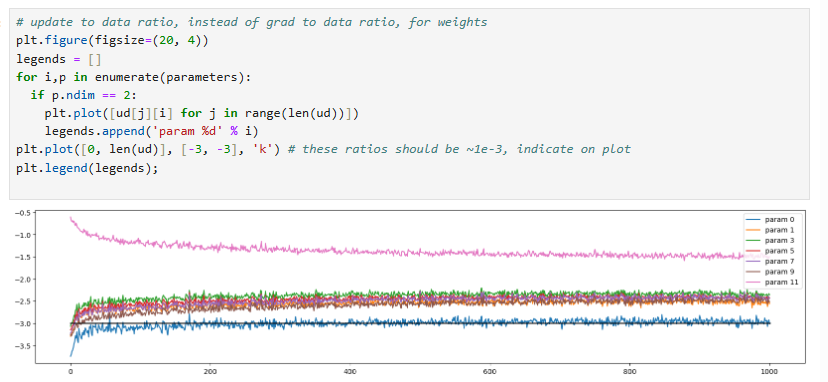

-> Why is the last layer an outlier? Why is it learning so much more dramatically than the other layers? Well, its because we artifically set the last layer to be very low when we were trying to make the last layers predictions less confident


with torch.no_grad():
  # last layer: make less confident
  layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3



lets now introduce batch normalization, so that we dont really need to worry about gain setting

here are the changes:

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  # layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

with this change, the activation and gradient of the nonlinearity, and the grad:dataf for weights ratio is pretty robust'
-> the update:data ratio is still affected though, so we dont get all that much of a free pass and do need to pay attention to the gain when initalizing our data values (or retune the learning rate if you change the gain)

TLDR: with batch norm we are a lot more robust to the gain and normalizing to the 1 / sqrt fan in and the grad:data for weights, but we do need to worry about the update:data ratio and tweak the learning rate accordingly

In [134]:
"""
SUMMARY OF SECTION:

1) intro to batch norm, one of the first modern solutions that help stabalize very deep neural network and their trainnig

2) PyTorch-ify our model (Linear class, BatchNorm1D, Tanh modules) 

3) diagnostic tools to check if the nn is in a good state
-> stats histogram of the forward pass activations
-> stats histogram of the back pass gradients
-> weights and how they are going to be updated - mean of grad, stddev of grad, and ratio of grad:data
-> weights and how they are going to be updated - ratio of update (lr * grad):data over time

"""

'\nSUMMARY OF SECTION:\n\n\n'